In [1]:
import torch
import torchtext
from torch import nn
import time
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda:1


# 1. Load the dataset

In [2]:
import sys
import os
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

# 2.EDA - exploratory data analysis

In [3]:
import pytreebank
dataset = pytreebank.load_sst()
train = dataset['train']
valid = dataset['dev']
test = dataset['test']

In [4]:
#Data Example
for t in train:
    for label,sentence in t.to_labeled_lines():
        print(label)
        print(sentence)
        break
    break

3
The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .


In [5]:
#Checking Label
set([label for t in train for label, sentence in t.to_labeled_lines()])

{0, 1, 2, 3, 4}

In [6]:
#length of each dataset
train_size = len(list(iter(train)))
valid_size = len(list(iter(valid)))
test_size = len(list(iter(test)))

train_size,valid_size,test_size
#It return only first root

(8544, 1101, 2210)

In [7]:
def seperate(dataset): #Use All nodes
    seperation = []
    for data in dataset:
        for label, text in data.to_labeled_lines():
            seperation.append((label,text))
    return seperation

In [8]:
train_sep = seperate(train)
valid_sep = seperate(valid)
test_sep = seperate(test)

In [9]:
train_size = len(list(iter(train_sep)))
valid_size = len(list(iter(valid_sep)))
test_size = len(list(iter(test_sep)))

train_size,valid_size,test_size

(318582, 41447, 82600)

# 3. Preprocessing

In [10]:
## 3.1 Tokenizing
import spacy
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('spacy',language='en_core_web_sm')
#check whether the tokenizer works....
# tokens = tokenizer('Chaky likes deep learning very much and wants his student to be nubmer 1 in Asia')
# tokens

In [11]:
# 3.2 Numericalization
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data_iter): #data_iter, e.g., train
    for _, text in data_iter: 
        yield tokenizer(text)
    
vocab = build_vocab_from_iterator(yield_tokens(train_sep), specials=['<unk>','<pad>','<bos>','<eos>'], special_first = True)

In [12]:
vocab.set_default_index(vocab["<unk>"]) #if you don't the id of this word, set it unk

In [13]:
vocab(['Chaky','likes','deep','learning','very','much','and','wants','his','student','to','be','nubmer','1','in','Asia'])

[0, 6138, 602, 5318, 85, 64, 8, 919, 36, 2733, 9, 28, 0, 3233, 14, 8506]

In [14]:
id2word = vocab.get_itos()

In [15]:
id2word[0]

'<unk>'

In [16]:
vocab(['<pad>','<bos>','<eos>'])

[1, 2, 3]

In [17]:
len(vocab)

17136

# 4. FastText embeddding

In [18]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple')

In [19]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)

In [20]:
fast_embedding.shape

torch.Size([17136, 300])

In [21]:
fast_embedding[100][:10]

tensor([-0.0595, -0.0829,  0.0264, -0.2511, -0.0340,  0.2841,  0.1026, -0.0634,
         0.0880,  0.1869], device='cuda:1')

# 5. Preparing dataloader

In [22]:
label_pipeline = lambda x: int(x)  #0,1,2,3 
text_pipeline = lambda x: vocab(tokenizer(x))

In [23]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence #mkaing each batch batch same length

pad_ix = vocab['<pad>']

#this function gonna be called by DataLoader
def collate_batch(batch):
    label_list, text_list, length_list = [],[],[]
    for (_label,_text) in batch:
        label_list.append(label_pipeline(_label)) # (3, 1, 0, 2, 1)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64) #(0, 44, 25, 1)
        text_list.append(processed_text)
        length_list.append(processed_text.size(0)) #for padding
    return torch.tensor(label_list,dtype=torch.int64), \
        pad_sequence(text_list, padding_value=pad_ix,batch_first=True), \
        torch.tensor(length_list,dtype=torch.int64)

In [24]:
batch_size = 64

train_loader = DataLoader(train_sep,batch_size=batch_size,
                            shuffle=True,collate_fn=collate_batch)
val_loader = DataLoader(valid_sep,batch_size=batch_size,
                            shuffle=True,collate_fn=collate_batch)
test_loader = DataLoader(test_sep,batch_size=batch_size,
                            shuffle=True,collate_fn=collate_batch)

# 6. Designing the model

In [25]:
class LSTM(nn.Module):
    def __init__(self,input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout):
        super().__init__()
        #input dim = how many vocab you have
        #emb dim = 300 --> we use fasttext
        #padding_idx tells this lookup to ignore and just randomize....
        #<unk>, <bos>, <eos>
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_ix)
        self.lstm = nn.LSTM(emb_dim, 
                            hid_dim, 
                            num_layers = num_layers, 
                            bidirectional = bidirectional, 
                            dropout = dropout, #dropout is applied between layers
                            batch_first = True) 
        self.fc = nn.Linear(hid_dim*2, output_dim)
        
    def forward(self, x, lengths):

        #x : [batch size, seq len]
        embedded_x = self.embedding(x)
        #x : [batch size, seq len, emb dim]

        #pack this embedded_x in such a way that RNN knows to ignore padding....
        #without batch first = True; thing will become [seq len, batch size, emb size]
        pack_embedded = nn.utils.rnn.pack_padded_sequence(embedded_x, 
                                                            lengths.to('cpu'),
                                                            enforce_sorted=False,
                                                            batch_first=True)
        #packed_output is basically all hidden states ==> POS tagging, NER
        
        #h is the last hidden state => sentiment analysis
        #c is the last cell state
        packed_output, (h,c) = self.lstm(pack_embedded)

        #h : [num_layers * num_directions, batch_size, hidden dim] 

        #it happen that because packed_ouputs is all hidden states... some hidden state near the end is
        #hidden state for padding, pytorch guys help you
        #by using this pack_padded_sequence, them all the hiddden states will only be not padding
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output,batch_first=True)

        #last hidden state - concat forward and backward states
        last_hidden_state = torch.cat((h[-1,:,:], h[-2,:,:]), dim = 1)
        #last_hidden_state: [batch_size, hidden_dim * 2]

        #for sentiment analysis... what whould i sent to my linear layer.....
        return self.fc(last_hidden_state) #[batch_size, output_dim] ==> [batch_size,5]

In [26]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [27]:
input_dim  = len(vocab)
hid_dim    = 256
emb_dim    = 300         #**<----change to 300
output_dim = 5 #five classes

#for biLSTM
num_layers = 2
bidirectional = True
dropout = 0.5

model = LSTM(input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout).to(device)
model.apply(initialize_weights)
model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [28]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

5140800
307200
262144
  1024
  1024
307200
262144
  1024
  1024
524288
262144
  1024
  1024
524288
262144
  1024
  1024
  2560
     5
______
7863109


In [29]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy

### Putting everything together

In [30]:
def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

In [31]:
def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text, text_length).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text, text_length) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text, text_length).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length


train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(val_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [32]:
# Function to calculate time.
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [33]:
best_valid_loss = float('inf')
num_epochs      = 10
tolerance_counter = 0

save_path = f'{model.__class__.__name__}_TreeBank.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        tolerance_counter = 0
        torch.save(model.state_dict(), save_path)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    # Tolerance techniques, stop the model if it start to overfit.
    if tolerance_counter >= 3:
        break

    tolerance_counter = tolerance_counter + 1

Epoch: 01 | Time: 1m 52s
	Train Loss: 0.485 | Train Acc: 80.52%
	 Val. Loss: 0.454 |  Val. Acc: 81.51%
Epoch: 02 | Time: 1m 48s
	Train Loss: 0.352 | Train Acc: 85.32%
	 Val. Loss: 0.451 |  Val. Acc: 82.14%
Epoch: 03 | Time: 1m 56s
	Train Loss: 0.312 | Train Acc: 86.90%
	 Val. Loss: 0.470 |  Val. Acc: 80.19%
Epoch: 04 | Time: 1m 56s
	Train Loss: 0.282 | Train Acc: 88.15%
	 Val. Loss: 0.490 |  Val. Acc: 80.13%
Epoch: 05 | Time: 2m 1s
	Train Loss: 0.256 | Train Acc: 89.22%
	 Val. Loss: 0.531 |  Val. Acc: 78.74%


Text(0, 0.5, 'loss')

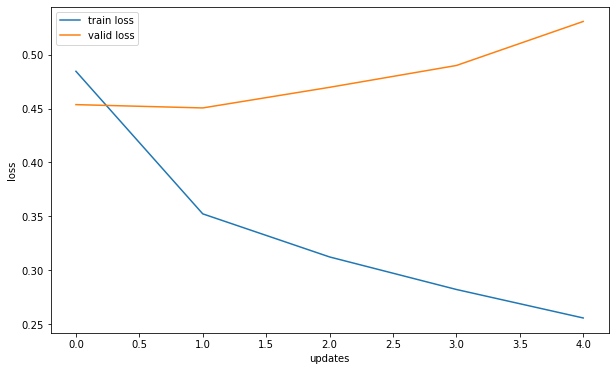

In [34]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

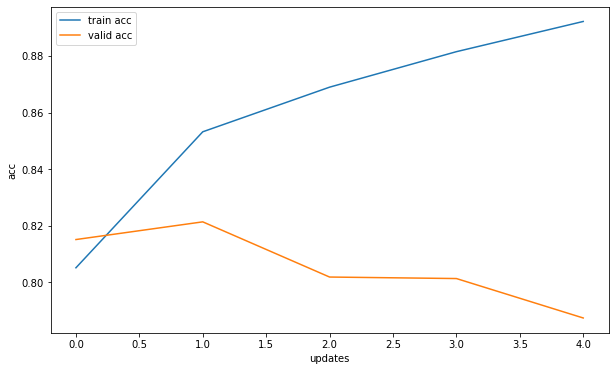

In [35]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [36]:
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = evaluate(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.458 | Test Acc: 81.94%
